In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

from sklearn import linear_model
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

## Data Preprocessing 

Lets start by Data Cleaning. We will remove features to simplify the model

In [4]:
grouped_df = df.groupby(['area_type'])['price'].agg(min_price='min', max_price='max').reset_index()

print(grouped_df)

              area_type  min_price  max_price
0        Built-up  Area       9.00     2050.0
1          Carpet  Area      13.00      500.0
2            Plot  Area       8.44     3600.0
3  Super built-up  Area       8.00     2912.0


 Since the min and max range is quite far we can drop the area_type column

In [5]:
df.drop(['area_type'], axis=1, inplace=True)
df.head()

,availability,location,size,society,total_sqft,bath,balcony,price
0,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
# Group by 'are_type' and calculate the list of prices and the mean price
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
grouped_df = df.groupby(['society','total_sqft'])['price'].agg(min_price='min', max_price='max', average_price='mean').reset_index()

filtered_grouped_df = grouped_df[(grouped_df['max_price'] - grouped_df['min_price']) > 10]

print(filtered_grouped_df)


      society total_sqft  min_price  max_price  average_price
57    AWharde       3198      200.0     250.00     225.000000
99    Adeatlm       2180      170.0     240.00     196.666667
100   Adeatlm       2275      175.0     187.00     181.800000
106   Adeatlm       4000      578.0     600.00     589.000000
107   Adeatlm       5400      700.0     750.00     725.000000
...       ...        ...        ...        ...            ...
5548  Vaniai        1045       58.0      76.77      70.513333
5561  Vaodssh       3600      245.0     260.00     252.500000
5572  Vapasrk       3035      220.0     271.00     245.500000
5602  Veales        1250       72.0      85.00      78.500000
5707  Wiowsri        950       40.0      57.00      47.333333

[341 rows x 5 columns]


For the same society with same total_sqft the prices vary too much. Hence, we can drop society. Also, since we have location we can afford to get rid of society.

In [7]:
df.drop(['society'], axis=1, inplace=True)
df.head()

,availability,location,size,total_sqft,bath,balcony,price
0,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [8]:
# Group by 'are_type' and calculate the list of prices and the mean price
grouped_df = df.groupby(['location','availability'])['price'].agg(prices=list).reset_index()
grouped_df['prices_len'] = grouped_df['prices'].apply(lambda x: len(x))
filtered_grouped_df = grouped_df[(grouped_df['availability'] ) != 'Ready To Move']
# filtered_grouped_df = filtered_grouped_df[(filtered_grouped_df['prices_len'] ) > 1]
print(filtered_grouped_df)


                     location availability              prices  prices_len
3                 Bhoganhalli       19-Dec             [22.89]           1
5         Devarachikkanahalli       18-May              [44.0]           1
9                Rachenahalli       18-May              [19.8]           1
10               Rachenahalli       20-Aug              [28.0]           1
12                Thanisandra       18-Nov             [25.25]           1
...                       ...          ...                 ...         ...
2359             manyata park       18-Nov      [84.83, 61.99]           2
2360        manyata tech park       18-Apr              [56.0]           1
2361  mvj engineering college       18-Jul             [56.53]           1
2372                 tc.palya       18-Apr  [62.0, 55.0, 78.0]           3
2376               whitefiled       20-Dec             [32.73]           1

[1174 rows x 4 columns]


availablity has effect on the final price hence we will keep it

### Handling Missing Data

In [9]:
df.isnull().sum()

availability      0
location          1
size             16
total_sqft        0
bath             73
balcony         609
price             0
dtype: int64

In [10]:
df = df.dropna()

In [11]:
df.isnull().sum()

availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [12]:
# rows_with_na = df[df['size'].isna()]
# rows_with_na['indexes'] = df[df['size'].isna()].index
# merged_df = pd.merge(rows_with_na, df, on=['location', 'total_sqft'], suffixes=('_left', '_right'))

# # Fill NaN values in 'size' column with either 'size_left' or 'size_right'
# merged_df['size'] = merged_df['size_left'].fillna(merged_df['size_right'])
# merged_df['bath'] = merged_df['bath_left'].fillna(merged_df['bath_right'])
# merged_df['balcony'] = merged_df['balcony_left'].fillna(merged_df['balcony_right'])

# # Drop unnecessary columns
# suffixes_to_drop = ['_left', '_right']
# merged_df = merged_df.drop([col + suffix for col in ['size', 'bath', 'balcony','availability','price'] for suffix in suffixes_to_drop], axis=1)
# print(merged_df)

# # Display the merged DataFrame with filled NaN values
# for index, i in merged_df.iterrows():
#     print(i)
#     print(df[(df['location']==i.location)  & ( (df['total_sqft'] > i.total_sqft-100) & (df['total_sqft'] < i.total_sqft+100))])
# # df[(df['location']=='IVC Road')  & ( (df['total_sqft'] > 3800) & (df['total_sqft'] < 3900))]
# df.loc[merged_df.indexes.tolist(), ['size', 'bath', 'balcony']] = merged_df[['size', 'bath', 'balcony']].values

# df.head()

### Data Transformation

Since the total_sqft column has str values we need to transform them into floating point numbers

In [13]:
def convert_sqft_to_num(x):
    if pd.isna(x):
        return np.nan
    if '-' in x:
        parts = x.split('-')
        return (float(parts[0]) + float(parts[1])) / 2
    try:
        return float(x)
    except ValueError:
        y = re.match(r'\d+', x)
        y = float(y.group())
        if 'Sq. Meter' in x:
            return y * 10.7639
        if 'Sq. Yards' in x:
            return y * 9
        if 'Guntha' in x:
            return y * 1089
        if 'Cents' in x:
            return y * 435.6
        if 'Grounds' in x:
            return y * 2400
        if 'Perch' in x:
            return y * 272.25
        return np.nan

# Apply the function to the total_sqft column
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

# Display the DataFrame
df.head()

,availability,location,size,total_sqft,bath,balcony,price
0,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00
4,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00


In [14]:
df['total_sqft'].describe()

count     12702.000000
mean       1577.113001
std        5928.892913
min           5.000000
25%        1100.000000
50%        1260.000000
75%        1640.000000
max      653400.000000
Name: total_sqft, dtype: float64

### Handling Categorical Data

We need to change the size from categorical to numerical 

In [15]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '3 Bedroom', '1 BHK', '1 RK',
       '4 BHK', '1 Bedroom', '2 Bedroom', '6 Bedroom', '8 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '11 Bedroom', '43 Bedroom',
       '14 BHK', '8 BHK', '12 Bedroom', '10 Bedroom', '13 BHK'],
      dtype=object)

In [16]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.drop(['size'], axis=1, inplace=True)
df.head()

,availability,location,total_sqft,bath,balcony,price,bhk
0,19-Dec,Electronic City Phase II,1056.0,2.0,1.0,39.07,2
1,Ready To Move,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4
2,Ready To Move,Uttarahalli,1440.0,2.0,3.0,62.00,3
3,Ready To Move,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3
4,Ready To Move,Kothanur,1200.0,2.0,1.0,51.00,2


In [17]:
df.isnull().sum()

availability    0
location        0
total_sqft      8
bath            0
balcony         0
price           0
bhk             0
dtype: int64

### Feature Engineering 

Dimentionality Reduction - Since there are a lot of diff locations lets group some of them 

In [18]:
print('Unique Locations Before changing case = ', len(df['location'].unique()))
df['location'] = df['location'].str.lower()
print('Unique Locations After changing case = ', len(df['location'].unique()))
df_location_stats = df.groupby(['location'])['location'].agg('count')
df_location_stats.sort_values(ascending=False)

Unique Locations Before changing case =  1265
Unique Locations After changing case =  1256


location
whitefield         514
sarjapur  road     372
electronic city    300
kanakpura road     261
thanisandra        231
                  ... 
junnasandra          1
k r c kothanur       1
kadarenahalli        1
kadubisnahalli       1
zuzuvadi             1
Name: location, Length: 1256, dtype: int64

In [19]:
df_locations_less_than_10 = df_location_stats[df_location_stats<=10]
print('Locations to be grouped = ',len(df_locations_less_than_10))

df['location']=df['location'].apply(lambda x: 'other' if x in df_locations_less_than_10 else x)
print('Unique Locations finally =', len(df['location'].unique()))

Locations to be grouped =  1019
Unique Locations finally = 238


Lets make a new column for price per sqft

In [20]:
df['price_per_sqft']=df['price']*100000/df['total_sqft']
df.head()

,availability,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,19-Dec,electronic city phase ii,1056.0,2.0,1.0,39.07,2,3699.810606
1,Ready To Move,chikka tirupathi,2600.0,5.0,3.0,120.00,4,4615.384615
2,Ready To Move,uttarahalli,1440.0,2.0,3.0,62.00,3,4305.555556
3,Ready To Move,lingadheeranahalli,1521.0,3.0,1.0,95.00,3,6245.890861
4,Ready To Move,kothanur,1200.0,2.0,1.0,51.00,2,4250.000000


### Outlier Removal

We can assume that a bedroom is of 200sqft at the very least, so we should remove those entries where the room sizes are too small

In [21]:
print('Total rows =',df.shape)
print('Outliers to be removed =',df[df['total_sqft']/df['bhk']<200].shape)

df = df[~(df['total_sqft']/df['bhk']<200)]
print('Total rows =',df.shape)

Total rows = (12710, 8)
Outliers to be removed = (284, 8)
Total rows = (12426, 8)


The prices per sqft values varies too much. Lets remove the outliers.

In [22]:
df['price_per_sqft'].describe()

count     12418.000000
mean       6376.428391
std        4158.396488
min          44.383226
25%        4210.526316
50%        5306.671056
75%        7000.000000
max      176470.588235
Name: price_per_sqft, dtype: float64

In [23]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df = remove_pps_outliers(df)
df.shape

(10250, 8)

In [24]:
df['price_per_sqft'].describe()

count    10250.000000
mean      5665.357327
std       2281.139336
min        876.795163
25%       4230.769231
50%       5175.792088
75%       6457.410642
max      24000.000000
Name: price_per_sqft, dtype: float64

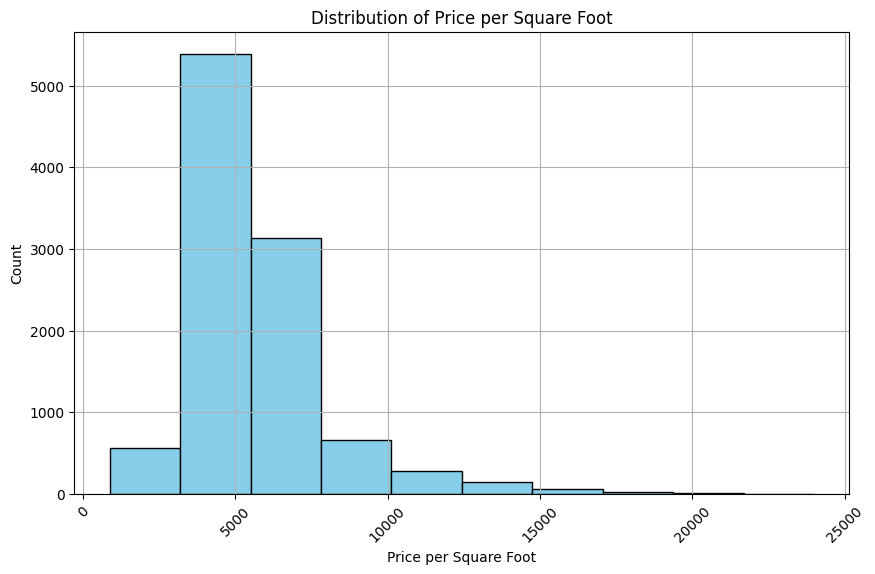

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(df['price_per_sqft'], bins=10, edgecolor='black', color='skyblue')
plt.xlabel('Price per Square Foot')
plt.ylabel('Count')
plt.title('Distribution of Price per Square Foot')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Our business logic states that it is unusual to have more than 2 bathrooms that total number of bedrooms in a house. So, we consider them outliers and remove them.

In [26]:
print(df[df['bhk']+2<df['bath']])
df = df[df['bhk']+2>=df['bath']]
df.shape

       availability       location  total_sqft  bath  balcony   price  bhk  \
1464  Ready To Move     chamrajpet      1500.0   9.0      3.0   230.0    6   
1598  Ready To Move  chikkabanavar      2460.0   7.0      2.0    80.0    4   
5805  Ready To Move          other     11338.0   9.0      1.0  1000.0    6   
7056  Ready To Move          other      1200.0   9.0      3.0   122.0    6   
9007  Ready To Move    thanisandra      1806.0   6.0      2.0   116.0    3   

      price_per_sqft  
1464    15333.333333  
1598     3252.032520  
5805     8819.897689  
7056    10166.666667  
9007     6423.034330  


(10245, 8)

In [27]:
df['availability'].unique()

array(['18-May', 'Ready To Move', '20-May', '18-Jun', '17-Dec', '15-Dec',
       '22-Jun', '19-Dec', '19-Jan', '19-Mar', '20-Mar', '18-Oct',
       '18-Jan', '18-Jul', '18-Mar', '18-Apr', '21-Sep', '21-Dec',
       '17-Nov', '18-Dec', '17-Jul', '18-Aug', '19-Oct', '19-Apr',
       '19-May', '17-Sep', '17-Aug', '20-Jan', '17-Jun', '17-May',
       '18-Nov', '17-Oct', '17-Apr', '20-Dec', '20-Oct', '21-Feb',
       '19-Feb', '22-Dec', '19-Jun', '18-Sep', '19-Jul', '22-Jan',
       '19-Aug', '20-Jun', '19-Sep', '19-Nov', '18-Feb', '17-Mar',
       '21-Jul', '22-Nov', '21-Aug', '16-Oct', '16-Mar', '21-Mar',
       '20-Aug', '16-Dec', '20-Sep', '16-Sep', '22-May', '22-Mar',
       '21-May', '21-Oct', '21-Jan', '16-Nov', '21-Nov', '16-Jul',
       '15-Jun', '20-Nov', '20-Apr', '14-Jul', '20-Jul', '17-Jan',
       '21-Jun', '20-Feb', '14-Nov', '15-Aug'], dtype=object)

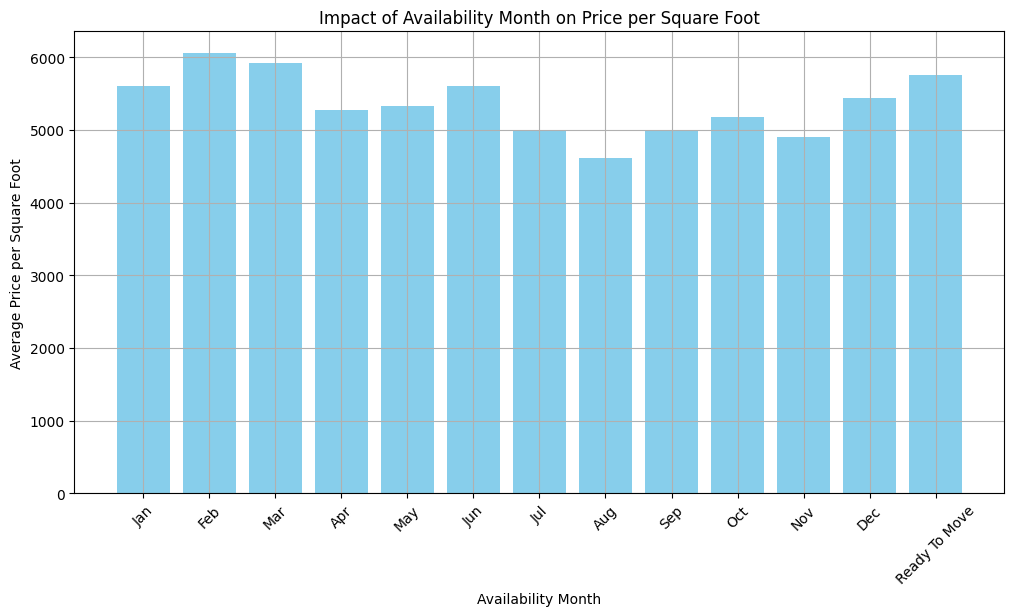

In [28]:
def extract_month(date_str):
    if date_str == "Ready To Move":
        return date_str
    return date_str.split('-')[1]

df['availability_month'] = df['availability'].apply(extract_month)

df_grouped = df.groupby('availability_month')['price_per_sqft'].mean().reset_index()

months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Ready To Move']
df_grouped['availability_month'] = pd.Categorical(df_grouped['availability_month'], categories=months_order, ordered=True)
df_grouped = df_grouped.sort_values('availability_month')

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['availability_month'], df_grouped['price_per_sqft'], color='skyblue')
plt.xlabel('Availability Month')
plt.ylabel('Average Price per Square Foot')
plt.title('Impact of Availability Month on Price per Square Foot')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [29]:
df.drop(['availability','price_per_sqft'],axis=1,inplace=True)

In [30]:
dummies_location = pd.get_dummies(df.location, dtype=int)
dummies_location.drop(['other'],axis=1,inplace=True)

dummies_availability = pd.get_dummies(df.availability_month, dtype=int)
dummies_availability.drop(['Ready To Move'],axis=1,inplace=True)

In [31]:
df = pd.concat([df,dummies_location],axis=1)
# df = pd.concat([df,dummies_availability],axis=1)
df.drop(['location','availability_month'],axis=1,inplace=True)
df.head()

,total_sqft,bath,balcony,price,bhk,devarachikkanahalli,1st block jayanagar,1st phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,...,vijayanagar,vishveshwarya layout,vishwapriya layout,vittasandra,whitefield,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yeshwanthpur
0,1250.0,2.0,3.0,44.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1250.0,2.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2.0,83.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2.0,40.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,2.0,65.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.shape

(10245, 242)

In [33]:
X = df.drop(['price'],axis=1)
y = df.price

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=10)

In [34]:
lr_clf = linear_model.LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.747602661296545

In [35]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
cross_val_score(linear_model.LinearRegression(), X, y, cv=cv)

array([0.74760266, 0.56770378, 0.59476669, 0.83993679, 0.79368761])

In [36]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': linear_model.LinearRegression(),
            'params': {
                
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.697213,{}
1,lasso,0.549537,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.645375,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [37]:
import pickle

with open('bengaluru_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [38]:
import json 
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json", "w") as f: 
    f.write(json.dumps(columns))